https://www.data.gouv.fr/en/datasets/contours-osm-des-cantons-electoraux-departementaux-2015/

https://www.insee.fr/fr/statistiques/3292622?sommaire=3292701

https://www.data.gouv.fr/fr/datasets/adresse-et-geolocalisation-des-etablissements-denseignement-du-premier-et-second-degres/

https://www.data.gouv.fr/fr/datasets/effectifs-deleves-des-etablissements-du-second-degre-public-et-prive-sous-tutelle-du-ministere-en-charge-de-leducation-nationale/

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj, transform
from tqdm import tqdm

inProj = Proj(init='epsg:2154')
outProj = Proj(init='epsg:4326')
sizeProj = Proj(init='epsg:3035')

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.path as mpltPath

In [2]:
geo = pd.read_csv('geo.csv', sep=';', encoding='latin-1')
geo = geo.drop(columns=['Unnamed: 10'])
geo.columns = ['uai', 'name', 'denom', 'patronym', 'X', 'Y', 'state', 'nature', 'lib_nature', 'ss_fic']
geo = geo.set_index('uai')
geo = geo.drop((geo[geo['X'] == '       . ']).index)
geo = geo.drop((geo[geo['X']=='G.GERARD']).index)
geo['X'] = geo['X'].astype(float)
geo['Y'] = geo['Y'].astype(float)
geo['X'], geo['Y'] = transform(inProj,outProj,geo[['X', 'Y']].values[:, 0],geo[['X', 'Y']].values[:, 1])

/Users/hugo/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
effectifs = pd.read_csv('effectifs.csv', sep=';')
effectifs.columns = ['year', 'uai', 'academia', 'type', 'sector', 
                     'student_number', 'region_name', 'region_code', 'dep_code', 'dep']
effectifs = effectifs.set_index('uai')

In [4]:
effectifs.head()

year     academia     type  sector  student_number  \
uai                                                                 
0480022N  2015-2016  MONTPELLIER    LYCEE   PRIVE             345   
0480038F  2015-2016  MONTPELLIER  COLLEGE   PRIVE             273   
0480688M  2015-2016  MONTPELLIER    LYCEE  PUBLIC             343   
0490014Z  2015-2016       NANTES  COLLEGE  PUBLIC             439   
0490022H  2015-2016       NANTES  COLLEGE  PUBLIC             436   

               region_name  region_code dep_code             dep  
uai                                                               
0480022N         Occitanie         76.0       48          Lozère  
0480038F         Occitanie         76.0       48          Lozère  
0480688M         Occitanie         76.0       48          Lozère  
0490014Z  Pays-de-la-Loire         52.0       49  Maine-et-Loire  
0490022H  Pays-de-la-Loire         52.0       49  Maine-et-Loire

In [5]:
geo.head()

name                 denom  \
uai                                                                    
0010001W  Lycée professionnel Alexandre Bérard  LP LYCEE DES METIERS   
0010002X                 Collège Saint-Exupéry               COLLEGE   
0010005A                Collège Roger Poulnard               COLLEGE   
0010006B        Lycée polyvalent Saint-Exupéry      LYCEE POLYVALENT   
0010008D                 Collège Saint-Exupéry               COLLEGE   

                  patronym         X          Y  state  nature  \
uai                                                              
0010001W  ALEXANDRE BERARD  5.350236  45.974965    1.0   320.0   
0010002X     SAINT-EXUPERY  5.355651  45.962402    1.0   340.0   
0010005A    ROGER POULNARD  4.945985  46.317150    1.0   340.0   
0010006B     SAINT-EXUPERY  5.816645  46.116432    1.0   306.0   
0010008D     SAINT-EXUPERY  5.816495  46.115148    1.0   340.0   

                   lib_nature ss_fic  
uai                                   
0010001W  LYCEE PROFESSIONNEL      3  
0010002X              COLLEGE      3  
0010005A              COLLEGE      3  
0010006B     LYCEE POLYVALENT      3  
0010008D              COLLEGE      3

In [6]:
agg = effectifs.join(geo, on='uai')
colleges = agg[agg['lib_nature'] == 'COLLEGE']

In [7]:
colleges_paris = colleges[colleges['academia'] == 'PARIS']
colleges_creteil = colleges[colleges['academia'] == 'CRETEIL']
colleges_nantes = colleges[colleges['academia'] == 'NANTES']
colleges_versailles = colleges[colleges['academia'] == 'VERSAILLES']
colleges_rennes = colleges[colleges['academia'] == 'RENNES']

In [8]:
colleges_rennes['student_number'].describe()

count    1530.000000
mean      420.836601
std       216.478467
min        23.000000
25%       250.000000
50%       402.500000
75%       563.750000
max      1222.000000
Name: student_number, dtype: float64

In [9]:
colleges_nantes['student_number'].describe()

count    1636.000000
mean      464.193154
std       212.748918
min         5.000000
25%       319.000000
50%       448.000000
75%       593.250000
max      1450.000000
Name: student_number, dtype: float64

In [10]:
colleges_paris['student_number'].describe()

count     700.000000
mean      484.682857
std       196.268617
min        13.000000
25%       386.000000
50%       465.000000
75%       575.000000
max      1272.000000
Name: student_number, dtype: float64

In [11]:
colleges_nantes['dep'].unique()

array(['Maine-et-Loire', 'Mayenne', 'Vendée', 'Loire-Atlantique',
       'Sarthe', nan], dtype=object)

In [12]:
cantons_geo = json.load(open('cantons.json'))

In [13]:
dep_codes = colleges_nantes['dep_code'].unique()
cantons_in_dep = [i for i in cantons_geo['features'] if i['properties']['dep'] in dep_codes]

In [16]:
def add_0_if(string, j):
    if len(string) == 1 and j==1:
        return '0'+string
    elif len(string) == 2 and j==0:
        return '0'+string
    return string

density_cantons = pd.read_csv('density_cantons_nantes.csv', delimiter=';')
density_cantons.columns = ['region_code', 'region_name', 'dep_code', 
                           'canton_code', 'canton_name', 'n_com', 'population_m', 'population']
density_cantons['population'] = np.fromiter(map(lambda x: x.replace(' ', ''), density_cantons['population']), dtype=np.float)
density_cantons['full_code'] = ['-'.join([add_0_if(str(t), j) for j, t in enumerate(i)]) for i in 
                                density_cantons[['dep_code', 'canton_code']].values]

In [17]:
all_pop = density_cantons['population'].sum()

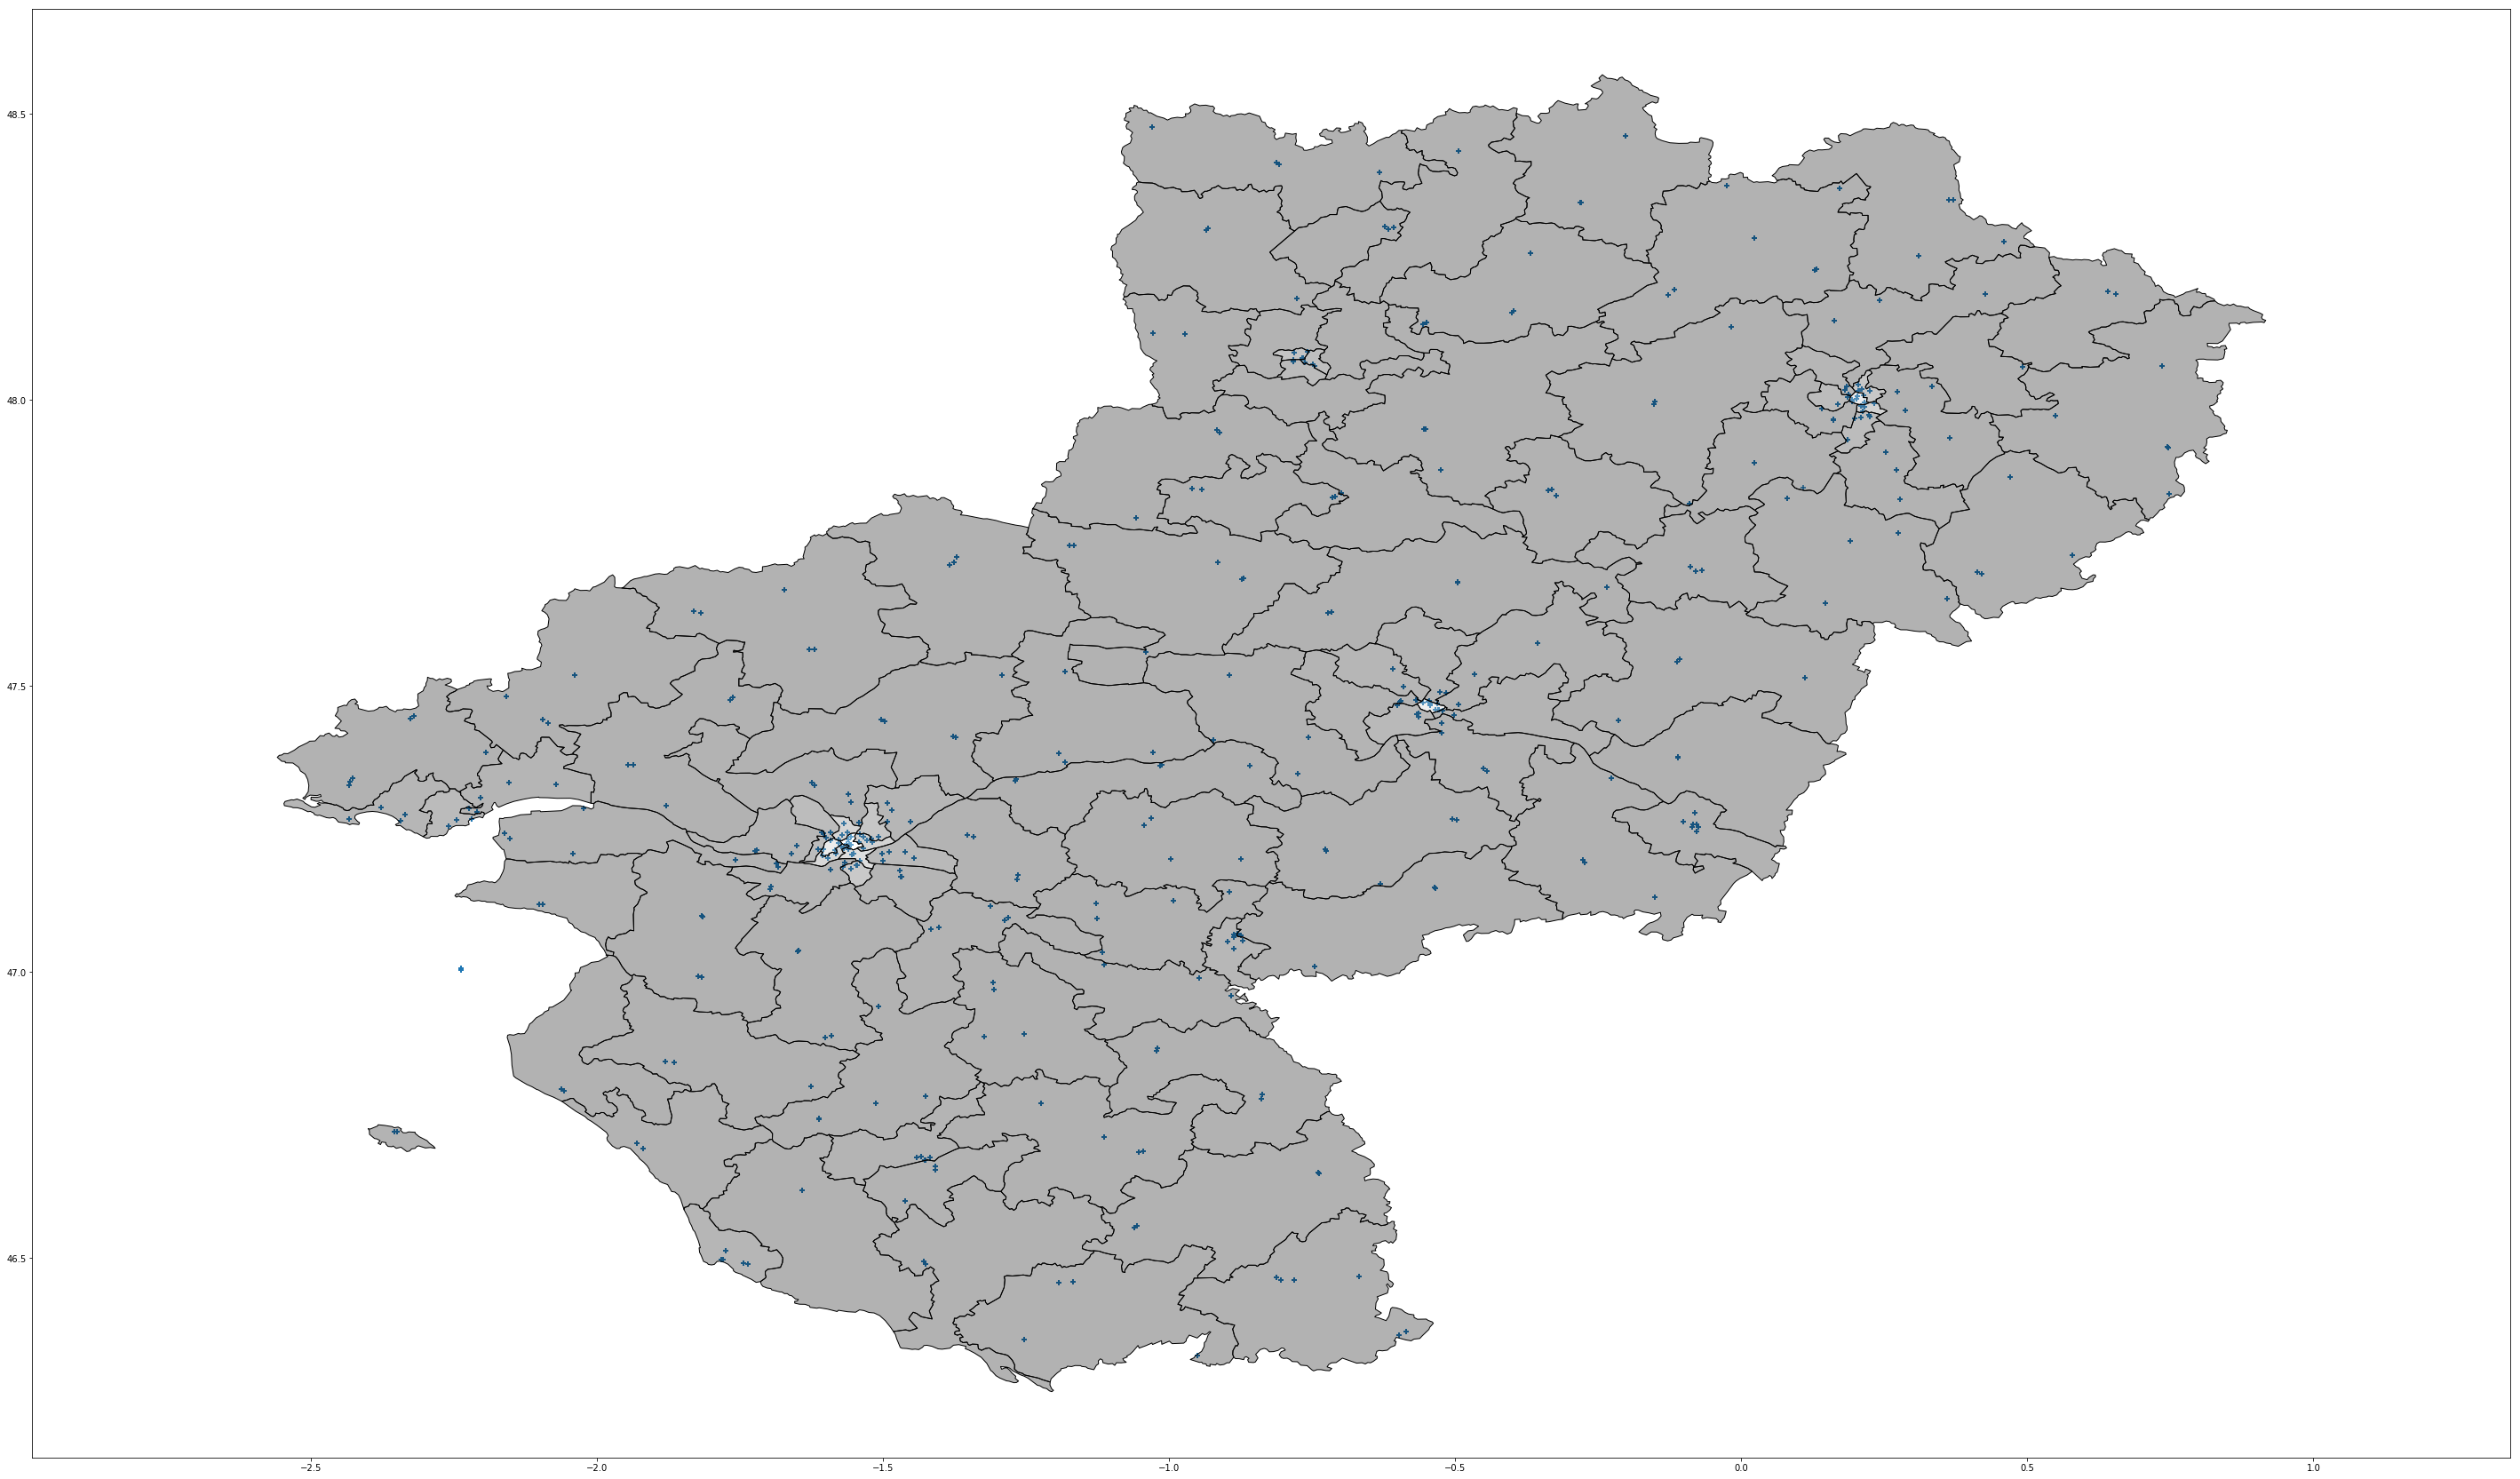

In [18]:
fig, ax = plt.subplots(figsize=(50, 30))
polygons = []

### https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates
### Shoelace method oneliner

poly_area = lambda x,y: 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

coords = []
areas = []
colors = []
dens = []


for canton in cantons_in_dep:
    coord = np.array(canton['geometry']['coordinates'][0]).reshape(-1, 2)
    coords.append(coord)
    coord_size_x, coord_size_y = transform(outProj, sizeProj, coord[:, 0] ,coord[:, 1])
    area = poly_area(coord_size_x, coord_size_y)  
    areas.append(area)
    val = density_cantons[density_cantons['full_code'] == canton['properties']['ref']]['population'].values[0]/(area*all_pop)
    dens.append(val)

min_x, max_x = (min(np.min(coord[:, 0]) for coord in coords),
                max(np.max(coord[:, 0]) for coord in coords))
min_y, max_y = (min(np.min(coord[:, 1]) for coord in coords),
                max(np.max(coord[:, 1]) for coord in coords))

all_paths = [mpltPath.Path(coord) for coord in coords]
path_to_dens = {path: dens[i] for i, path in enumerate(all_paths)}

def test_point_in(point, return_path=False):
    if return_path:
        for path in all_paths:
            if path.contains_point(point):
                return path
        return False
    return any(path.contains_point(point) for path in all_paths)

for j, canton in enumerate(cantons_in_dep):
    color_base = dens[j]
    
    
for j, canton in enumerate(cantons_in_dep):
    coord = coords[j]
    bs = dens[j]/max(dens)
    color = (bs, bs, bs, 0.3)
    poly = Polygon(coord, 
                   fill=True, 
                   color=color)
    poly.set_edgecolor('k')
    polygons.append(poly)

p = PatchCollection(polygons, match_original=True)

ax.scatter(colleges_nantes[['X', 'Y']].values[:, 0], 
           colleges_nantes[['X', 'Y']].values[:, 1],
           marker='+')

#unif_x = np.random.uniform(min_x, 
#                           max_x, size=1000)
#unif_y = np.random.uniform(min_y, 
#                          max_y, size=1000)

#for i in zip(unif_x, unif_y):
#    plt.scatter(i[0], i[1], c='k' if test_point_in(i) else 'g')


ax.add_collection(p)
ax.axis('equal')
plt.savefig('nantes.pdf')

In [24]:
all_paths[0].contains_points(np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), axis=1))

array([False, False, False, ..., False, False, False])

In [27]:
def pdf(x, y):
    ret = np.zeros(x.size)
    all_pts = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), axis=1)
    for path in all_paths:
        cont_bool = path.contains_points(all_pts)
        ret[cont_bool] = path_to_dens[path]
    return ret

N = 400
x, y = np.meshgrid(np.linspace(min_x,
                               max_x, N),
                   np.linspace(min_y,
                               max_y, N))

In [28]:
z = pdf(x.reshape(-1), y.reshape(-1)).reshape(N, N)

/Users/hugo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


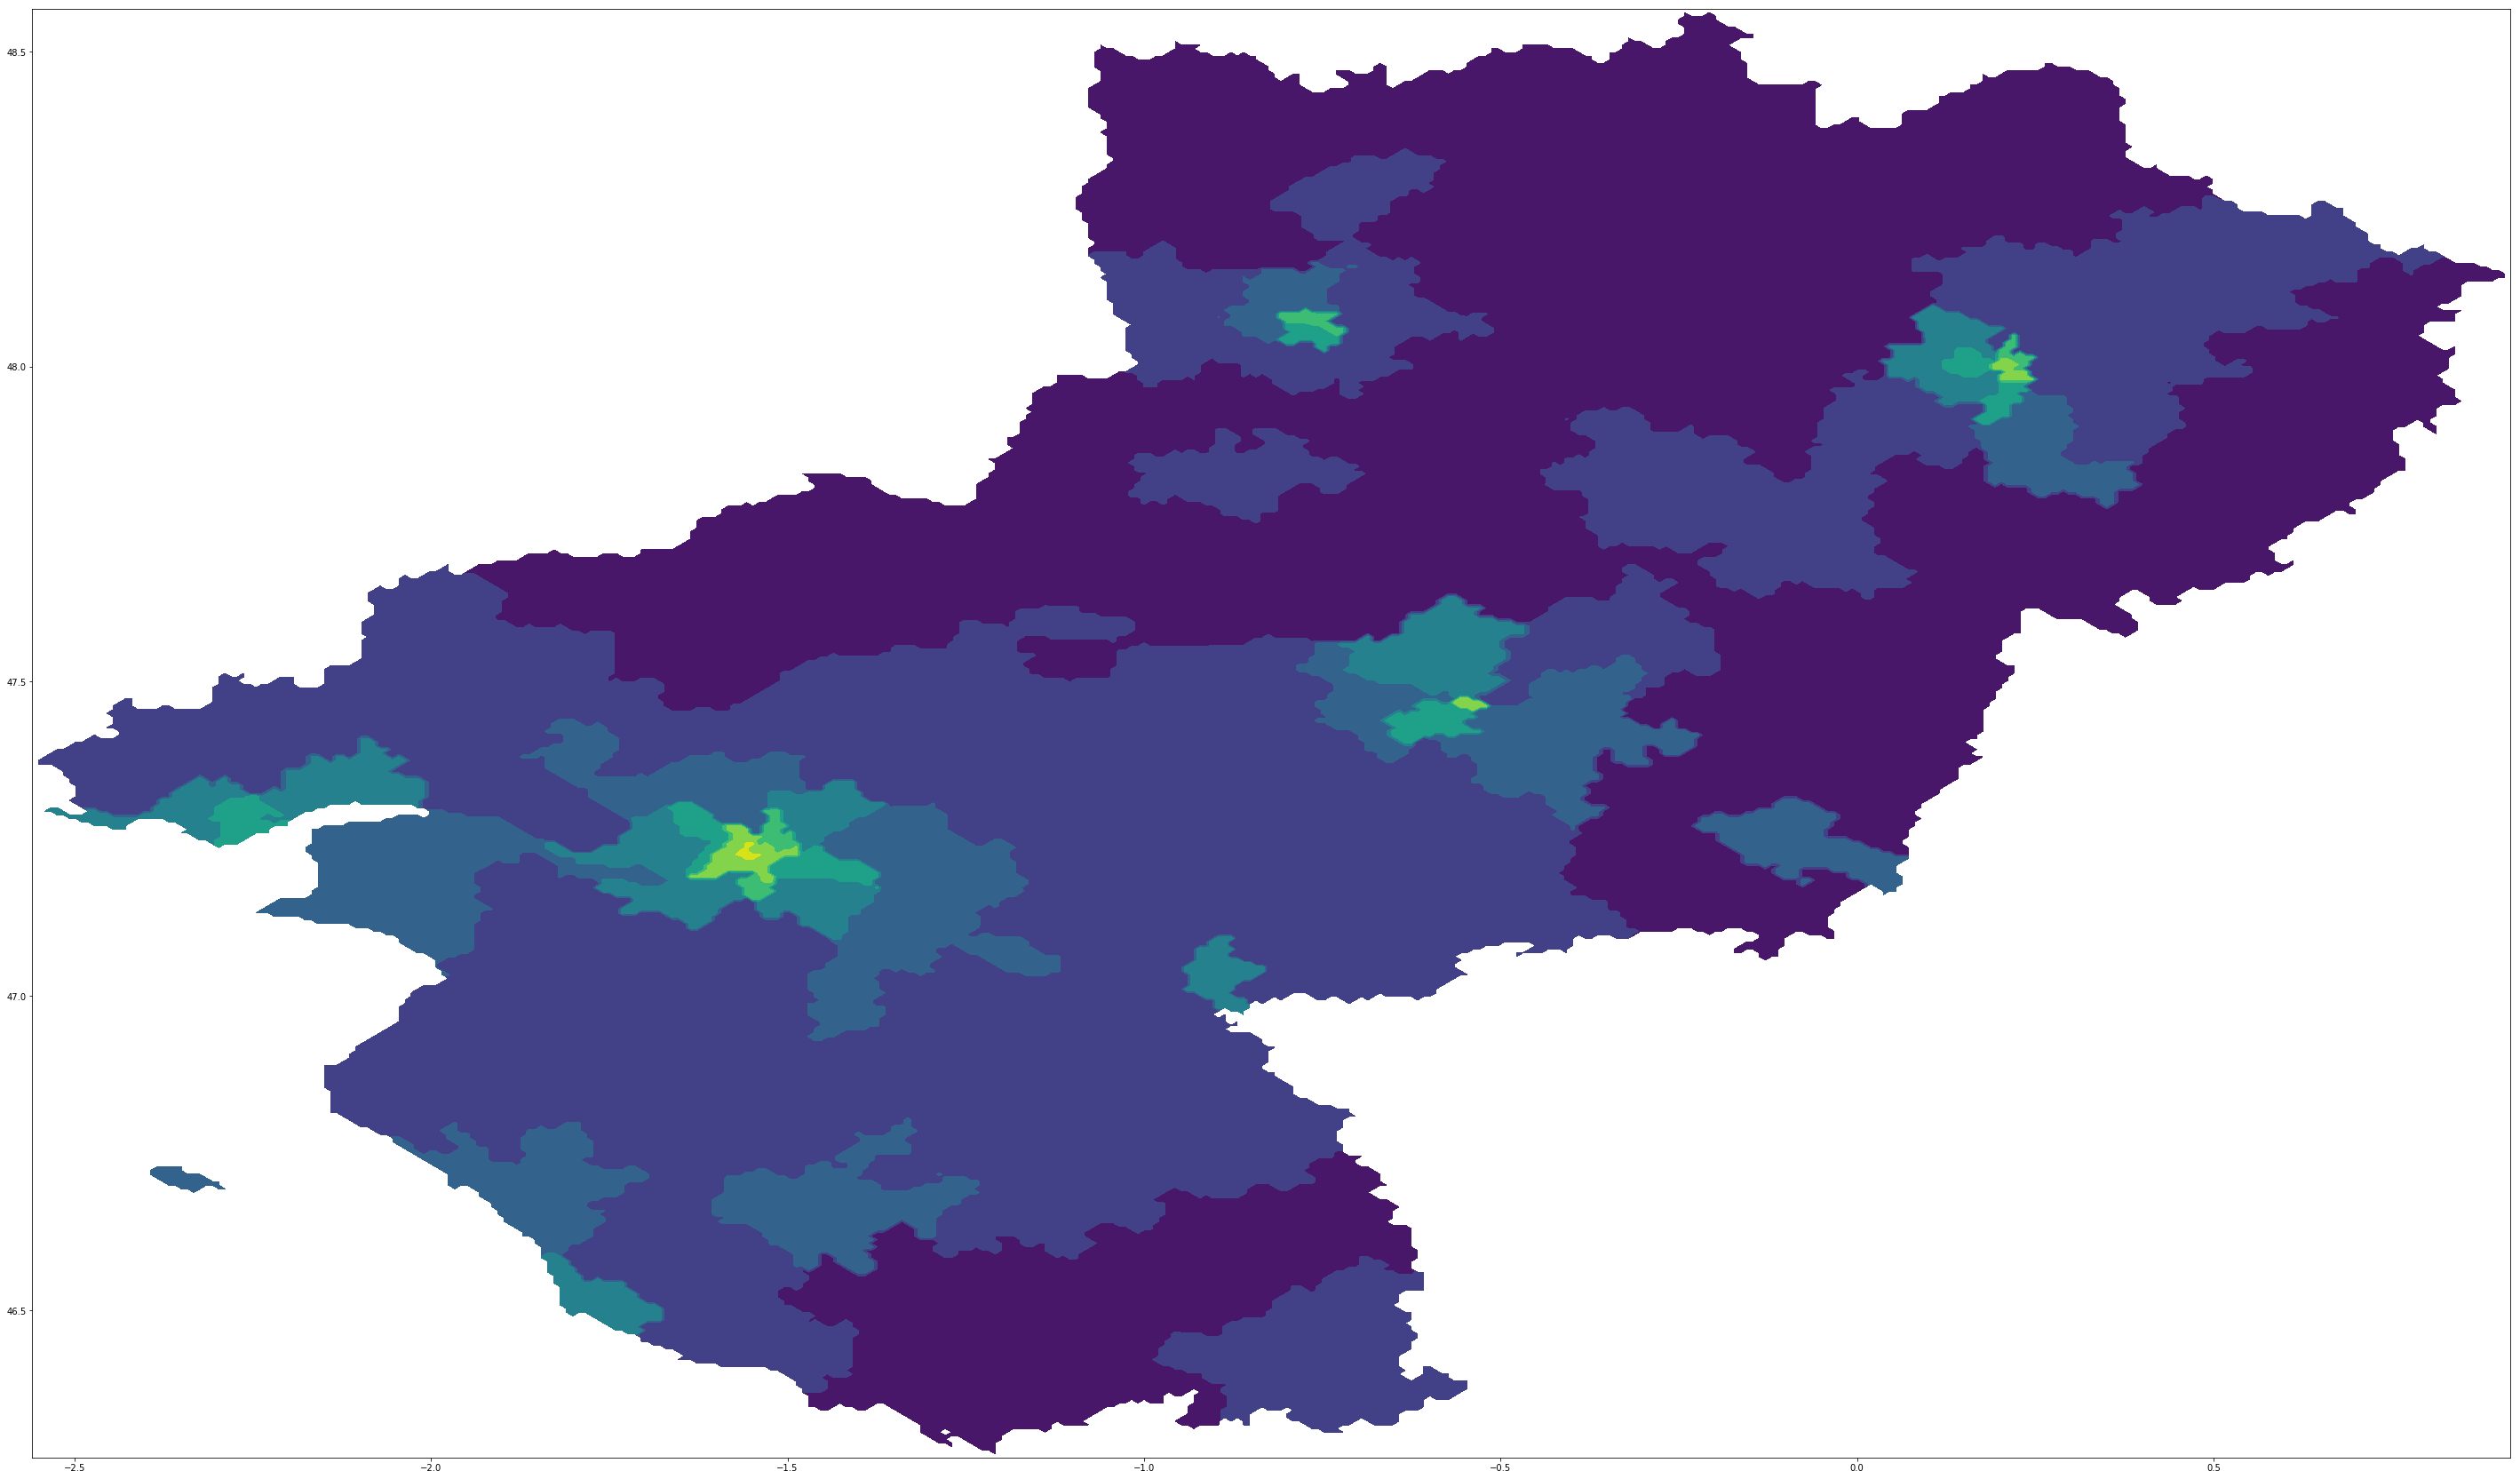

In [29]:
fig, ax = plt.subplots(figsize=(50, 30))
ax.contourf(x, y, np.log(z))

In [46]:
### https://stackoverflow.com/questions/21100716/fast-arbitrary-distribution-random-sampling
class Distribution(object):
    """
    draws samples from a one dimensional probability distribution,
    by means of inversion of a discrete inverstion of a cumulative density function

    the pdf can be sorted first to prevent numerical error in the cumulative sum
    this is set as default; for big density functions with high contrast,
    it is absolutely necessary, and for small density functions,
    the overhead is minimal

    a call to this distibution object returns indices into density array
    """
    def __init__(self, pdf, sort = True, interpolation = True, transform = lambda x: x):
        self.shape          = pdf.shape
        self.pdf            = pdf.ravel()
        self.sort           = sort
        self.interpolation  = interpolation
        self.transform      = transform

        #a pdf can not be negative
        assert(np.all(pdf>=0))

        #sort the pdf by magnitude
        if self.sort:
            self.sortindex = np.argsort(self.pdf, axis=None)
            self.pdf = self.pdf[self.sortindex]
        #construct the cumulative distribution function
        self.cdf = np.cumsum(self.pdf)
    @property
    def ndim(self):
        return len(self.shape)
    @property
    def sum(self):
        """cached sum of all pdf values; the pdf need not sum to one, and is imlpicitly normalized"""
        return self.cdf[-1]
    def __call__(self, N):
        """draw """
        #pick numbers which are uniformly random over the cumulative distribution function
        choice = np.random.uniform(high = self.sum, size = N)
        #find the indices corresponding to this point on the CDF
        index = np.searchsorted(self.cdf, choice)
        #if necessary, map the indices back to their original ordering
        if self.sort:
            index = self.sortindex[index]
        #map back to multi-dimensional indexing
        index = np.unravel_index(index, self.shape)
        index = np.vstack(index)
        #is this a discrete or piecewise continuous distribution?
        if self.interpolation:
            index = index + np.random.uniform(size=index.shape)
        return self.transform(index)

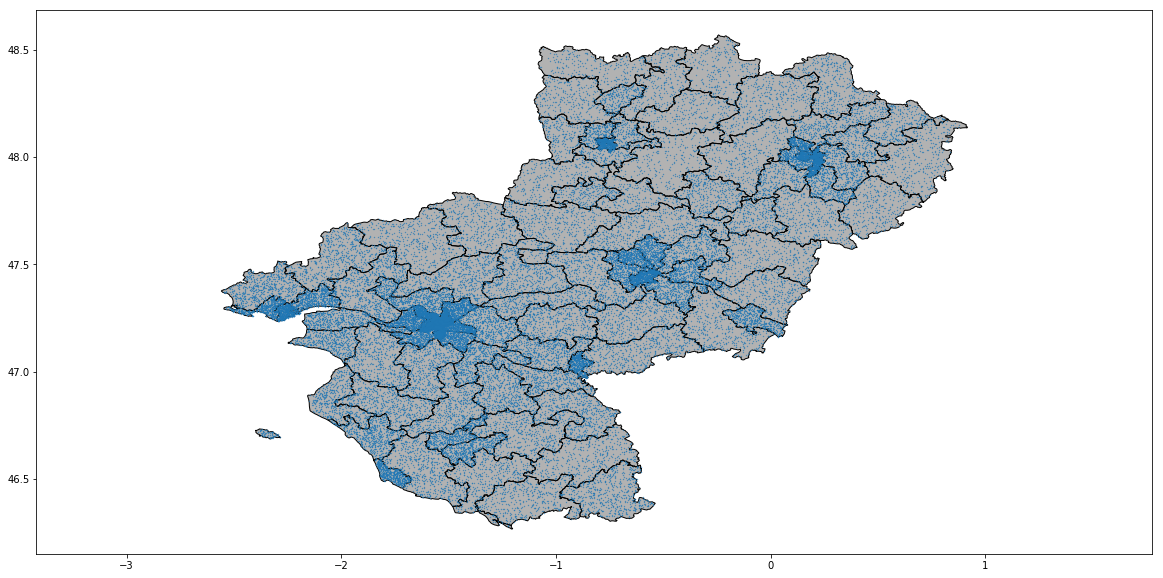

In [47]:
fig, ax = plt.subplots(figsize=(20, 10))
dist = Distribution(z, transform=lambda i:i, interpolation=True)

m = dist(50000).T
m[:,[0, 1]] = m[:,[1, 0]]
m[:, 0] = ((m[:, 0]/N)*(max_x-min_x) + min_x)
m[:, 1] = ((m[:, 1]/N)*(max_y-min_y) + min_y)

p = PatchCollection(polygons, match_original=True)
ax.add_collection(p)
ax.axis('equal')
ax.scatter(m[:,0], m[:, 1], s=0.1)


In [48]:
nu_supp = colleges_nantes[['X', 'Y']].values
nu = np.ones(nu_supp.shape[0])
nu/=nu.sum()

In [52]:
distance(nu_supp, dist(1).T).shape

(1636,)

In [91]:
v_tilde = np.zeros(nu.shape)
v = v_tilde.copy()
eps=0.05
distance = lambda x, nu_sup: np.sqrt(np.sum((nu_sup-x)**2, axis=1))/100
step = 0.01


for k in tqdm(range(1, 5000000)):
    x = dist(1).T
    c = distance(x, nu_supp)

    tmp = nu * np.exp((1/eps)*(v_tilde - c))
    grad = nu - tmp/tmp.sum()
    
    v_tilde = v_tilde + (step/np.sqrt(k))*grad
    v = (1/k)*v_tilde + (1-(1/k))*v

100%|██████████| 4999999/4999999 [10:52<00:00, 7661.77it/s]


In [92]:
x, y = np.meshgrid(np.linspace(m[:, 0].min(), m[:, 0].max(), 200), 
                   np.linspace(m[:, 1].min(), m[:, 1].max(), 200))

In [93]:
all_dists = np.sqrt(np.sum((np.concatenate((x.reshape(-1, 1), 
                            y.reshape(-1, 1)), 
                            axis=1).reshape(-1,1, 2) -  nu_supp)**2, axis=2))

expo = np.exp((v - all_dists)/eps)
g_ctrans = - eps* np.log(np.sum(expo*nu, axis=1))

In [94]:
f = np.exp((v - all_dists)/eps)
f /= f.sum(axis=1).reshape(-1, 1)

(-2.7326980499999993, 1.09037505, 46.1514494, 48.6833766)

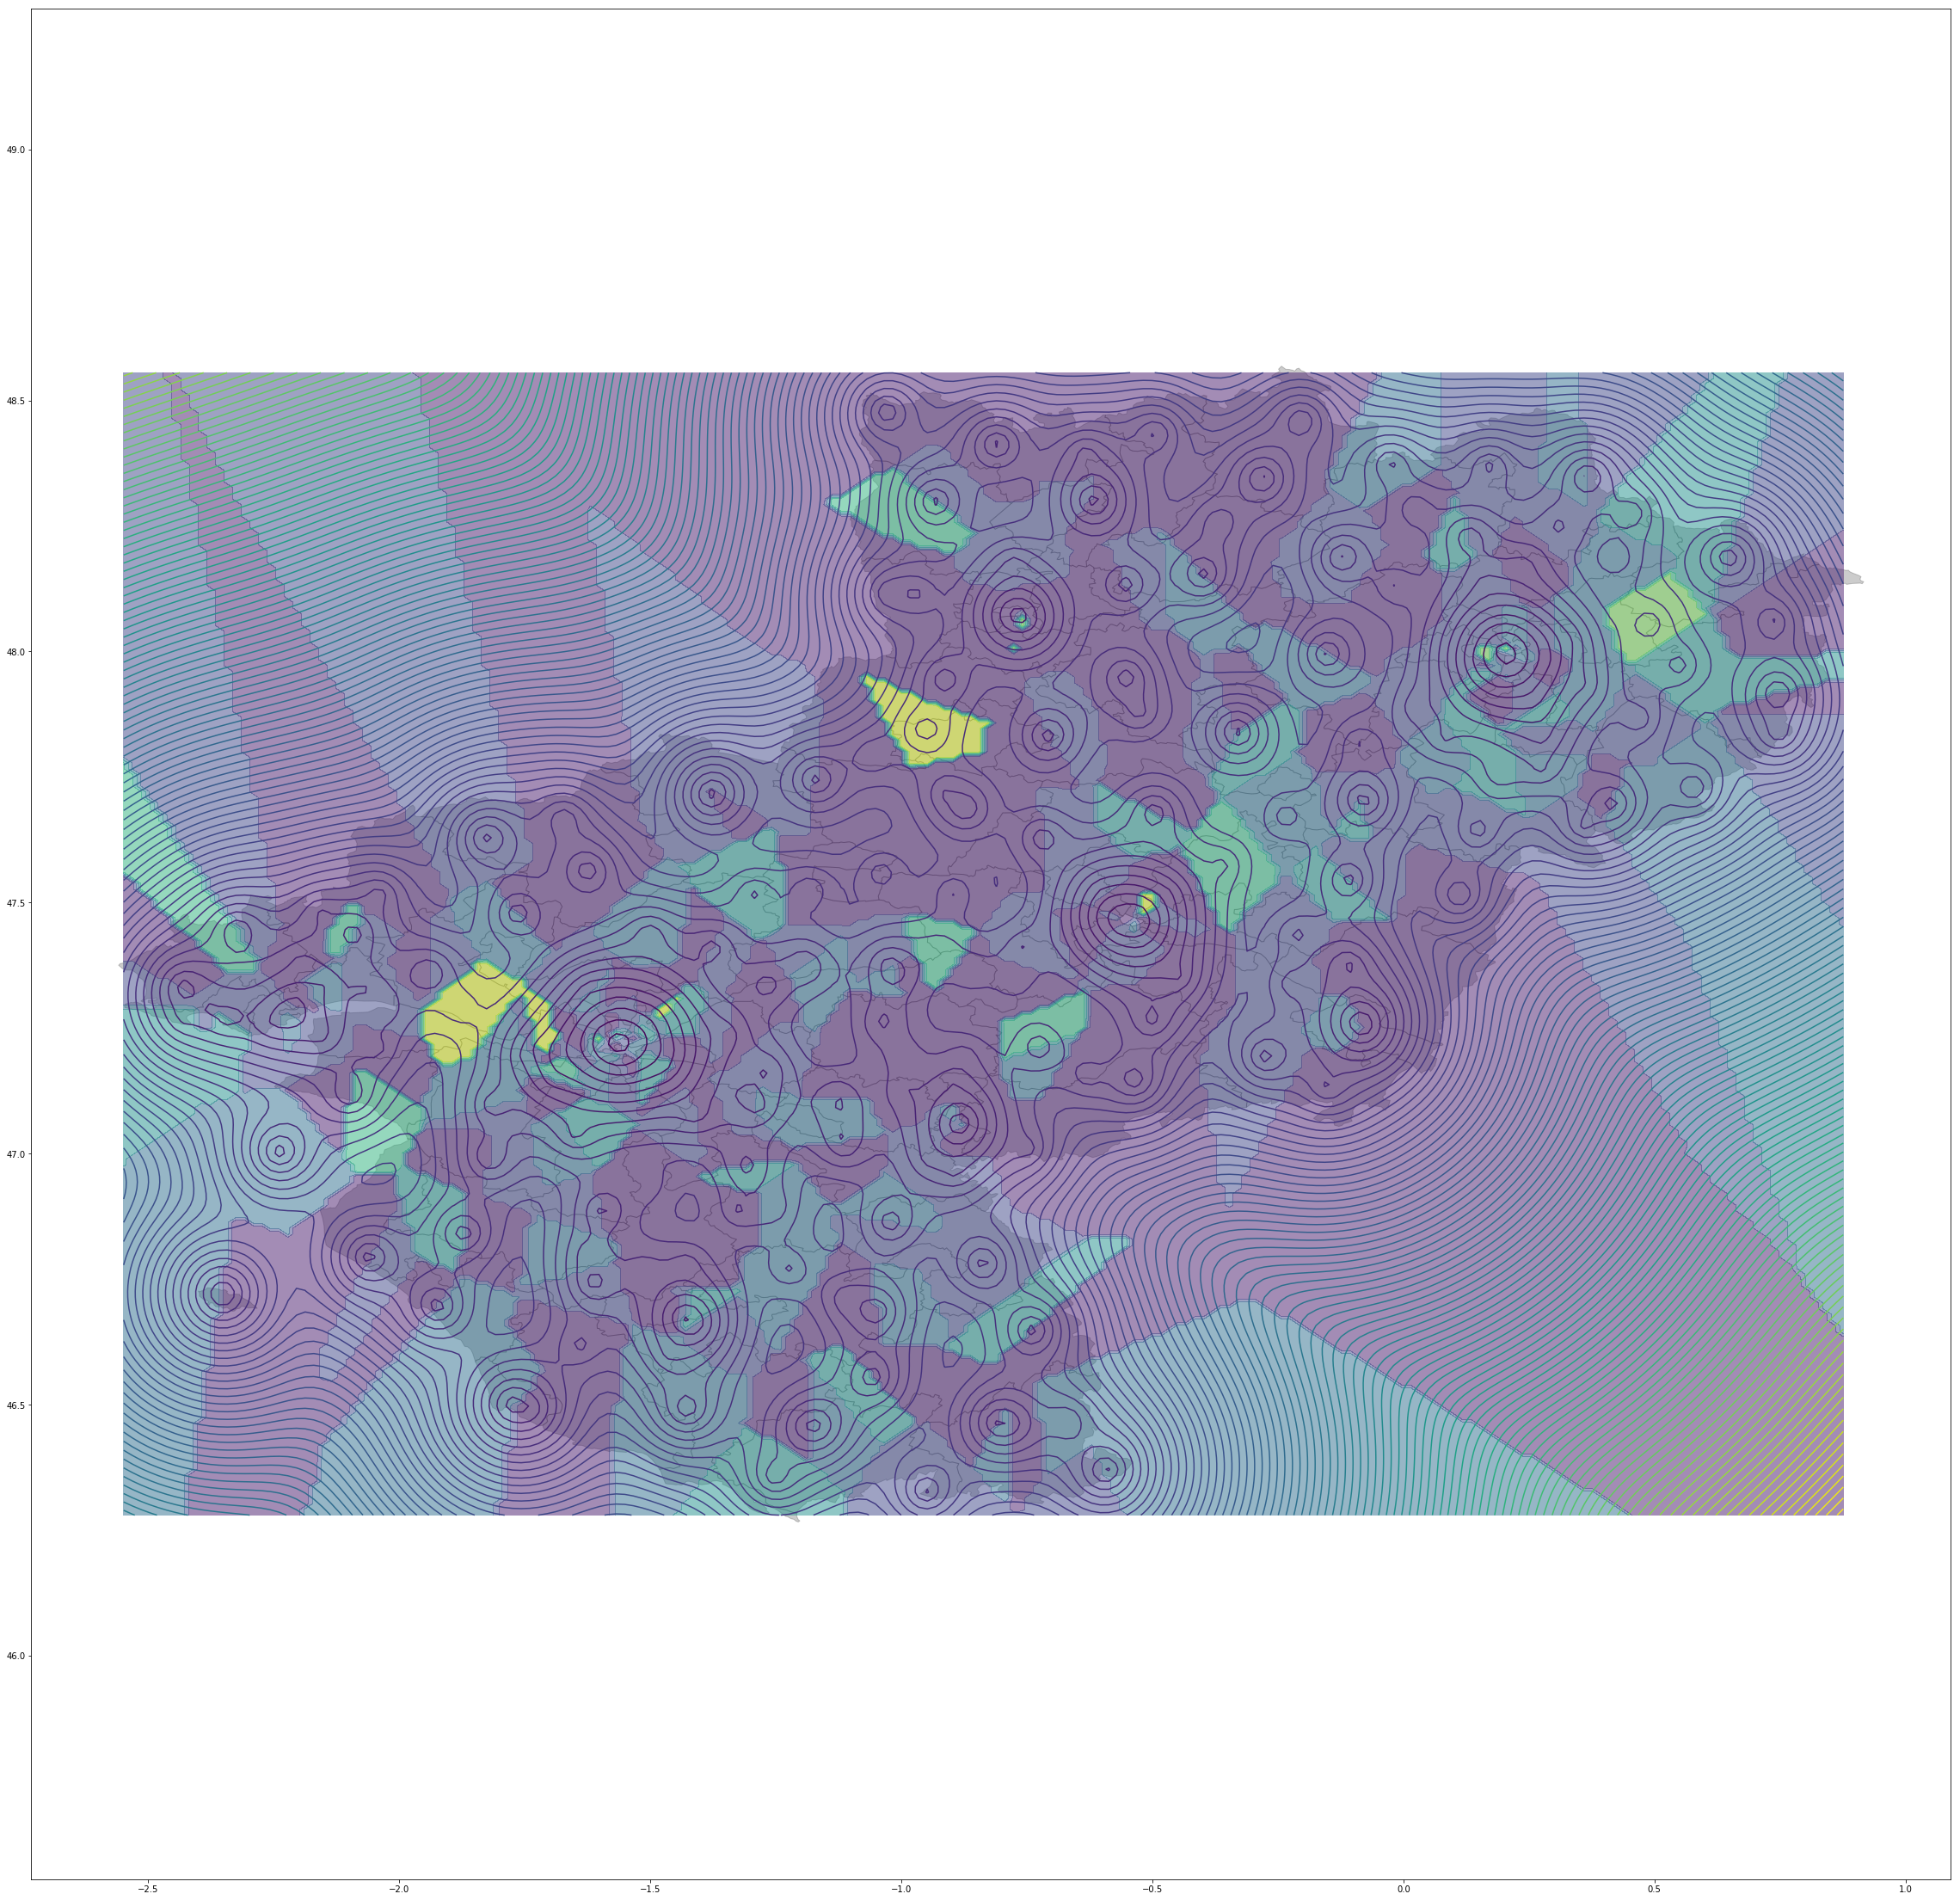

In [99]:
fig, ax = plt.subplots(figsize=(40, 40))
p = PatchCollection(polygons, match_original=True, alpha=0.2)
ax.add_collection(p)
ax.contour(x, y, g_ctrans.reshape(200, 200), 100)
ax.contourf(x, y, np.argmax(f, axis=1).reshape(200, 200), alpha=0.5)
ax.axis('equal')
